In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [2]:
header=['1','2','3','4','5','6','7','Wheat_Kernel']
wheat=pd.read_csv('D:\Environments\Projects\Wheat-Kernel-Classification\seeds_dataset.txt',sep='\t',header=None,names=header)
wheat.head()

,1,2,3,4,5,6,7,Wheat_Kernel
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1


#### Data was read into the file using the tab delimiter and the attributes were assigned as 1,...n.

In [3]:
wheat.describe()

,1,2,3,4,5,6,7,Wheat_Kernel
count,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000
mean,14.847524,14.559286,0.870999,5.628533,3.258605,3.700201,5.408071,2.000000
std,2.909699,1.305959,0.023629,0.443063,0.377714,1.503557,0.491480,0.818448
min,10.590000,12.410000,0.808100,4.899000,2.630000,0.765100,4.519000,1.000000
25%,12.270000,13.450000,0.856900,5.262250,2.944000,2.561500,5.045000,1.000000
50%,14.355000,14.320000,0.873450,5.523500,3.237000,3.599000,5.223000,2.000000
75%,17.305000,15.715000,0.887775,5.979750,3.561750,4.768750,5.877000,3.000000
max,21.180000,17.250000,0.918300,6.675000,4.033000,8.456000,6.550000,3.000000


In [4]:
wheat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   1             210 non-null    float64
 1   2             210 non-null    float64
 2   3             210 non-null    float64
 3   4             210 non-null    float64
 4   5             210 non-null    float64
 5   6             210 non-null    float64
 6   7             210 non-null    float64
 7   Wheat_Kernel  210 non-null    int64  
dtypes: float64(7), int64(1)
memory usage: 13.2 KB


#### No presence of null values.

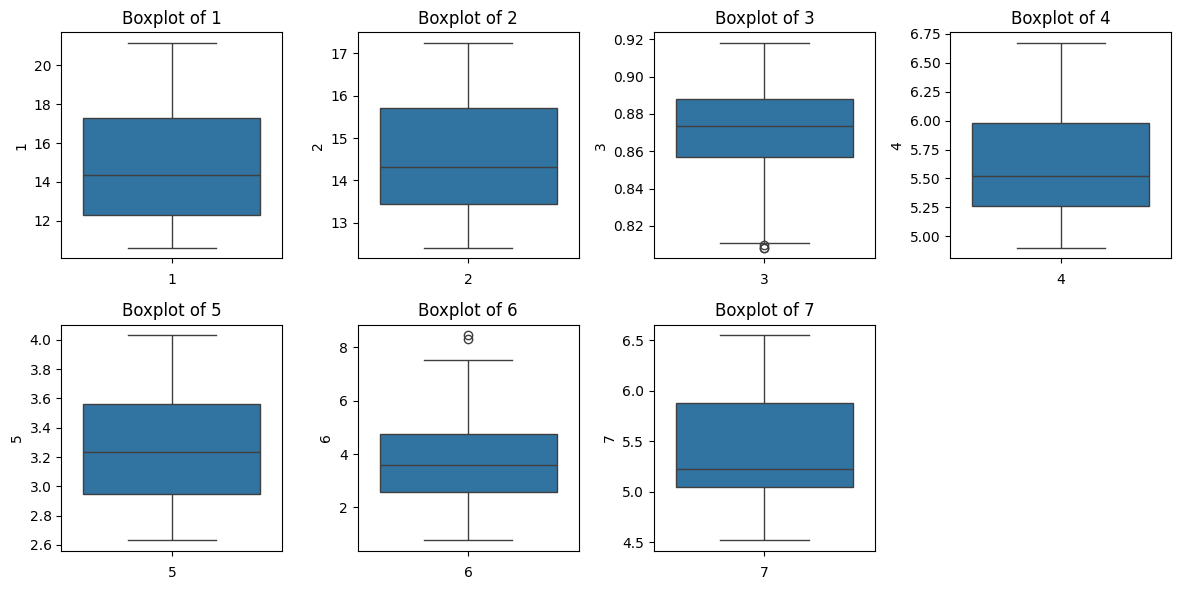

In [5]:
features = wheat.iloc[:, :-1]
plt.figure(figsize=(12, 6))
for i, column in enumerate(features.columns):
    plt.subplot(2, 4, i + 1)
    sns.boxplot(features[column])
    plt.title(f'Boxplot of {column}')
    plt.xlabel(column)
plt.tight_layout()
plt.show()

#### As it seems, there isn't any outlier in the attributes except just some in the 3rd one.

In [6]:
wheat.Wheat_Kernel.value_counts()

Wheat_Kernel
1    70
2    70
3    70
Name: count, dtype: int64

In [7]:
wheat.groupby('Wheat_Kernel').describe()

1                                                        \
             count       mean       std    min      25%     50%      75%   
Wheat_Kernel                                                               
1             70.0  14.334429  1.215704  11.23  13.7500  14.355  15.0450   
2             70.0  18.334286  1.439496  15.38  17.3300  18.720  19.1375   
3             70.0  11.873857  0.723004  10.59  11.2625  11.835  12.4250   

                        2             ...        6            7            \
                max count       mean  ...      75%    max count      mean   
Wheat_Kernel                          ...                                   
1             17.08  70.0  14.294286  ...  3.30100  6.685  70.0  5.087214   
2             21.18  70.0  16.135714  ...  4.43600  6.682  70.0  6.020600   
3             13.37  70.0  13.247857  ...  5.46725  8.456  70.0  5.116400   

                                                               
                   std    min     25%     50%      75%    max  
Wheat_Kernel                                                   
1             0.263699  4.519  4.9245  5.0940  5.22350  5.877  
2             0.253934  5.144  5.8775  5.9815  6.18775  6.550  
3             0.162068  4.745  5.0020  5.0915  5.22850  5.491  

[3 rows x 56 columns]

#### Each classes are evenly distributed. So no issue of imbalance.

In [8]:
x=wheat.drop('Wheat_Kernel',axis='columns')
y=wheat.Wheat_Kernel

In [9]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda=LDA(n_components=2)
x_lda=lda.fit_transform(x,y)

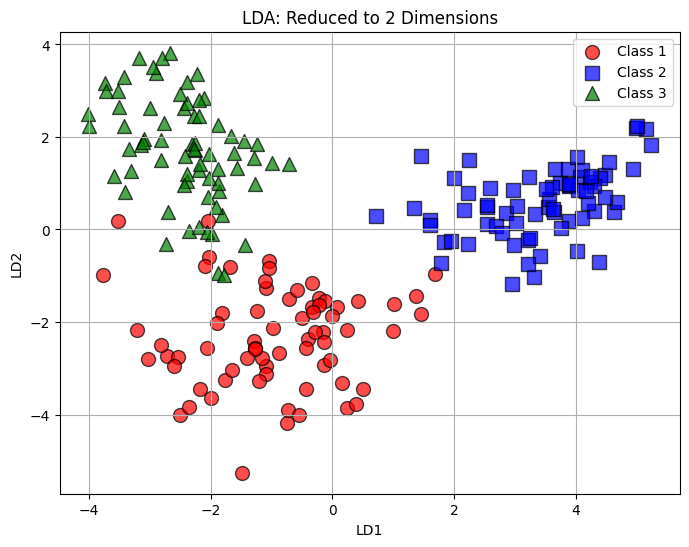

In [10]:
plt.figure(figsize=(8, 6))
markers = ['o', 's', '^']
colors = ['red', 'blue', 'green']
for idx, label in enumerate(np.unique(y)):
    plt.scatter(
        x_lda[y == label, 0], 
        x_lda[y == label, 1], 
        label=f"Class {label}",
        alpha=0.7,
        s=100,
        marker=markers[idx],
        color=colors[idx],
        edgecolor='k'
    )
plt.title("LDA: Reduced to 2 Dimensions")
plt.xlabel("LD1")
plt.ylabel("LD2")
plt.legend()
plt.grid(True)
plt.show()

#### Linear Discriminant Analysis aka LDA was performed to check wheather the classes are separable in respect to the variance ratio. Class 1 and 2 are clearly separable while there is some overlap between class 1 & 3.

In [11]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.20,stratify=y,random_state=42)

In [12]:
lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(x_train, y_train)
X_test_lda = lda.transform(x_test)

In [13]:
def find_best_model(X_train, y_train):
    models = {
        "Logistic Regression": LogisticRegression(),
        "SVM (Linear)": SVC(kernel='linear'),
        "Decision Tree": DecisionTreeClassifier(),
        "Random Forest": RandomForestClassifier()
    }
    
    param_grid = {
        "Logistic Regression": {
            'C': [0.01, 0.1, 1, 10]
        },
        "SVM (Linear)": {
            'C': [0.01, 0.1, 1, 10],
            'kernel': ['linear']
        },
        "Decision Tree": {
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10]
        },
        "Random Forest": {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5]
        }
    }
    
    best_model = None
    best_score = 0
    best_params = None
    
    for model_name, model in models.items():
        print(f"Tuning {model_name}...")
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid[model_name], cv=5, scoring='accuracy')
        grid_search.fit(X_train, y_train)
        if grid_search.best_score_ > best_score:
            best_score = grid_search.best_score_
            best_model = grid_search.best_estimator_
            best_params = grid_search.best_params_
    
    print(f"Best Model: {best_model}")
    print(f"Best Parameters: {best_params}")
    print(f"Best Cross-Validation Score: {best_score}")
    return best_model, best_params, best_score

In [14]:
best_model, best_params, best_score = find_best_model(X_train_lda, y_train)

Tuning Logistic Regression...
Tuning SVM (Linear)...
Tuning Decision Tree...
Tuning Random Forest...
Best Model: RandomForestClassifier(n_estimators=50)
Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}
Best Cross-Validation Score: 0.9823529411764707


In [15]:
clf = RandomForestClassifier(random_state=42,max_depth=None, min_samples_split=2,n_estimators=50)
clf.fit(X_train_lda, y_train)

y_pred = clf.predict(X_test_lda)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy after LDA: {accuracy:.2f}")
print(classification_report(y_pred,y_test))

Accuracy after LDA: 0.93
              precision    recall  f1-score   support

           1       0.86      0.92      0.89        13
           2       0.93      1.00      0.96        13
           3       1.00      0.88      0.93        16

    accuracy                           0.93        42
   macro avg       0.93      0.93      0.93        42
weighted avg       0.93      0.93      0.93        42



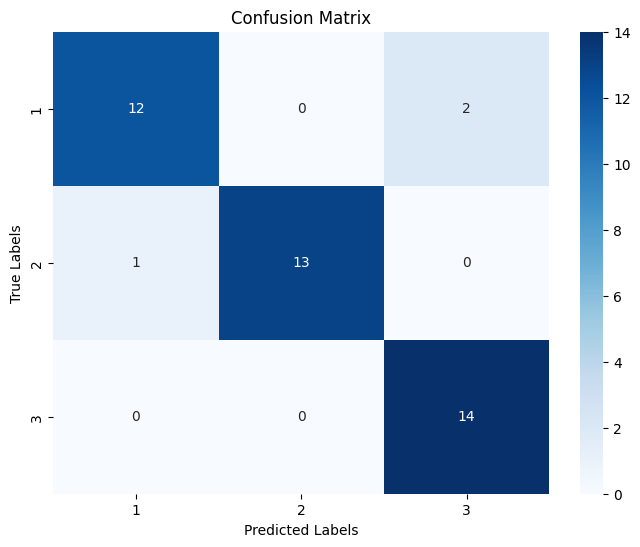

In [16]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

#### As it was seen in the LDA plot too, there are few misclassifications where 1 is predicted as 3. But apart from that, there are no misclassifications and the model seems to be working pretty good. Reducing the test size may increase more accuracy, but it may overfit the data.

In [17]:
import pickle

with open('clf.pkl', 'wb') as f:
    pickle.dump(clf, f)